In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser

#We have to add the plotting tools to the directory list with path.append
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

# Load water level data

In [21]:
gauge_data = pd.read_csv('/g/data/r78/kd6095/dea-notebooks/Tantangara/Tantangara_water_level.csv',
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

gauge_data_xr = gauge_data.to_xarray()

<xarray.Dataset>
Dimensions:     (Timestamp: 436)
Coordinates:
  * Timestamp   (Timestamp) datetime64[ns] 2018-08-24 2018-12-03 ... 1992-10-20
Data variables:
    Value       (Timestamp) float64 1.22e+03 1.22e+03 ... 1.229e+03 1.229e+03
    rownumber   (Timestamp) float64 7.053e+03 7.054e+03 ... 7.487e+03 7.488e+03
    Exceedence  (Timestamp) float64 5.822 5.809 5.795 ... 0.02671 0.01335

# Dask load WOfS data

In [4]:
lat, lon, buffer = -35.75, 148.66, 6500
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2000-01-01', '2019-01-01'), 
         'crs': 'EPSG:3577'} 

dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)
wofs_albers

<xarray.Dataset>
Dimensions:  (time: 1179, x: 521, y: 521)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
  * y        (y) float64 -3.997e+06 -3.997e+06 ... -4.01e+06 -4.01e+06
  * x        (x) float64 1.495e+06 1.495e+06 1.495e+06 ... 1.508e+06 1.508e+06
Data variables:
    water    (time, y, x) int16 dask.array<shape=(1179, 521, 521), chunksize=(1, 521, 521)>
Attributes:
    crs:      EPSG:3577

# Merge data

In [27]:
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)
merged_data

<xarray.Dataset>
Dimensions:     (time: 1179)
Coordinates:
    Timestamp   (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
  * time        (time) datetime64[ns] 2000-01-01T23:43:29.500000 ... 2018-12-28T23:50:34
Data variables:
    Value       (time) float64 1.209e+03 1.209e+03 ... 1.221e+03 1.221e+03
    rownumber   (time) float64 3.276e+03 3.013e+03 ... 7.258e+03 7.23e+03
    Exceedence  (time) float64 56.25 59.77 63.18 72.42 ... 3.712 3.084 3.456

# Specify which satellite passes to load based on water level

First, have a look at the duration curve to decide which level you want to look at

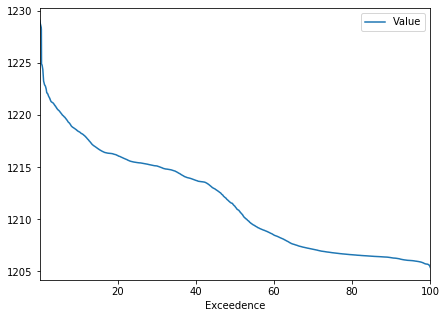

In [37]:
gauge_data.plot(x='Exceedence', y='Value', figsize=(7, 5))

Now see how many passes there have been when the water has been at that level. This is how many time points you have in the the time dimension.

In [29]:
specified_level = merged_data.where((merged_data.Value >1220) & (merged_data.Value < 1230), drop=True)
specified_level

<xarray.Dataset>
Dimensions:     (time: 73)
Coordinates:
    Timestamp   (time) datetime64[ns] 2010-12-13T23:46:42.500000 ... 2018-12-28T23:50:34
  * time        (time) datetime64[ns] 2010-12-13T23:46:42.500000 ... 2018-12-28T23:50:34
Data variables:
    Value       (time) float64 1.22e+03 1.22e+03 ... 1.221e+03 1.221e+03
    rownumber   (time) float64 7.114e+03 7.123e+03 ... 7.258e+03 7.23e+03
    Exceedence  (time) float64 5.008 4.889 4.58 4.659 ... 3.712 3.084 3.456

Here's a list of all the time points you have satellite passes for at the specified level.

In [33]:
date_list = specified_level.time.values
date_list

array(['2010-12-13T23:46:42.500000000', '2010-12-14T23:43:42.500000000',
       '2010-12-21T23:49:56.000000000', '2010-12-22T23:40:34.500000000',
       '2010-12-29T23:46:46.500000000', '2010-12-30T23:43:51.000000000',
       '2012-03-13T23:50:58.500000000', '2012-03-22T23:44:49.000000000',
       '2012-03-29T23:50:59.500000000', '2014-06-23T23:54:19.000000000',
       '2014-06-24T23:50:24.000000000', '2014-07-01T23:56:39.000000000',
       '2014-07-02T23:48:12.000000000', '2014-07-09T23:54:23.500000000',
       '2014-07-10T23:50:33.000000000', '2014-07-17T23:56:45.000000000',
       '2014-07-18T23:48:13.500000000', '2014-07-25T23:54:28.000000000',
       '2014-07-26T23:50:36.000000000', '2014-08-02T23:56:51.500000000',
       '2014-08-03T23:48:20.500000000', '2014-08-10T23:54:31.500000000',
       '2014-08-11T23:50:44.500000000', '2014-08-18T23:56:56.500000000',
       '2014-08-19T23:48:19.500000000', '2014-08-26T23:54:28.500000000',
       '2014-08-27T23:50:46.000000000', '2014-09-03